# Reproducting Experiments from Figure 1 of 'Randomness in neural network training: Characterizing the impact of tooling'

**Dataset**: CIFAR10

In [ ]:
#!pip install -q mle-logging
#!pip install pyhessian

### Imports

In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

## Standard Python
import os
import random

## Python additional
import numpy as np
import matplotlib.pyplot as plt

from mle_logging import MLELogger
from pyhessian import hessian

## PyTorch Imports

# PT
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler, Adam
# Torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms


### Random state initialization and Determinism

Adapted from this [this blog](https://wandb.ai/sauravmaheshkar/RSNA-MICCAI/reports/How-to-Set-Random-Seeds-in-PyTorch-and-Tensorflow--VmlldzoxMDA2MDQy) by Saurav Maheshkar

In [2]:
def set_seed(seed: int = 42, deterministic = False) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    
    if deterministic:
      torch.backends.cudnn.deterministic = True
      torch.backends.cudnn.benchmark = False
      #torch.use_deterministic_algorithms(True)
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

In [ ]:
experiment_seed = 1234

In [3]:
set_seed(seed          = experiment_seed,
         deterministic = True)

Random seed set as 1234


### Dataset download/initialization

In [4]:
"""classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')"""

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

training_dataset = CIFAR10(root='./data', train=True, download=True, transform=train_transform)

test_dataset = CIFAR10(root='./data', train=False, download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified



1. L2 Norm - To Add
2. Churn - To Add
3. STDDEV Accuracy - To add
7. FP16 - To add


In [6]:
class SimpleCNN(nn.Module):
  def __init__(self, use_bn = False):
    super(SimpleCNN, self).__init__()

    self.use_bn = use_bn

    # Conv Layers
    self.cnn_layer1 = nn.Conv2d(3,  16, kernel_size=3, padding=1)
    self.cnn_layer2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
    self.cnn_layer3 = nn.Conv2d(32, 32, kernel_size=3, padding=1)

    # Batch Norm
    if self.use_bn:
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(32)

    # Pooling
    self.max_pool = nn.MaxPool2d(2, stride=2)
    self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

    # Linear layers
    self.linear_layer1 = nn.Linear(32, 32)
    self.linear_layer2 = nn.Linear(32, 10)

  def forward(self, x):

    x = self.cnn_layer1(x)
    if self.use_bn:
      x = self.bn1(x)
    x = self.max_pool(F.relu(x))
    
    x = self.cnn_layer2(x)
    if self.use_bn:
      x = self.bn2(x)
    x = self.max_pool(F.relu(x))

    x = self.cnn_layer3(x)
    if self.use_bn:
      x = self.bn3(x)
    x = self.max_pool(F.relu(x))
    
    x = self.global_avg_pool(x)
    
    x = x.view(-1, 32)
    x = F.relu(self.linear_layer1(x))
    x = self.linear_layer2(x)
    return x    

In [44]:
class TrainingHarness:
      def __init__(self, train_params):
        self.train_params = train_params
        
        self.train_dl = DataLoader(training_dataset, batch_size = train_params['batch_size'], shuffle=True, num_workers=2)
        self.test_dl  = DataLoader(test_dataset, batch_size = train_params['batch_size'], shuffle=False, num_workers=2)
        self.protected_classes = self.train_params['protected_classes']
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.net = SimpleCNN(use_bn=self.train_params['bn'])
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=4e-4)
        self.scheduler = lr_scheduler.MultiStepLR(self.optimizer, milestones=[50, 100], gamma=0.1)
        self.criterion = nn.CrossEntropyLoss()
        
        self.net.to(self.device)

      def train_one_epoch(self):
        self.net.train()
        train_loss = 0.0
        train_correct = 0
        total = 0
        for data in tqdm.tqdm(self.train_dl):
            ims, labels = data
            ims, labels = ims.to(self.device), labels.to(self.device)

            self.optimizer.zero_grad()

            outputs = self.net(ims)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            train_loss += loss.item()
            _, pred = torch.max(outputs, 1) 
            train_correct += pred.eq(labels).sum().item()
            total += labels.size(0)

        train_loss /= len(self.train_dl)
        train_acc = (train_correct / total) * 100
        self.scheduler.step()
        return train_loss, train_acc

      def test_model(self):
        self.net.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        with torch.no_grad():
              predictions = []
              for data in self.test_dl:
                ims, labels = data
                ims, labels = ims.to(self.device), labels.to(self.device)
                outputs = self.net(ims)
                loss = self.criterion(outputs, labels)

                _, pred = torch.max(outputs, 1)
                predictions.extend(list(pred.cpu().numpy()))
                
                test_loss += loss.item()
                test_correct += pred.eq(labels).sum().item()
                test_total += labels.size(0)
        
        test_loss /= len(self.test_dl)
        test_accuracy = (test_correct / test_total) * 100
        return test_loss, test_accuracy, predictions

      def log_norm(self):
        grad_norm_dict = {0 : [], 1 : [], 2 : [], 3 : [], 4 : [], 5 : [], 6 : [], 7 : [], 8 : [], 9 : []}
        for data in self.test_dl:
            ims, labels = data
            ims, labels = ims.to(self.device), labels.to(self.device)
            outputs = self.net(ims)
            for i in self.protected_classes: # protected classes
                if len(labels[labels == i]) > 0:
                    self.net.zero_grad()
                    group_loss = self.criterion(outputs[labels == i], labels[labels == i])
                    group_loss.backward(retain_graph=True)
                    sub_norm = torch.norm(torch.stack([torch.norm(w.grad) for w in self.net.parameters() if w.grad is not None])).item()
                    grad_norm_dict[i].append(sub_norm)

        return grad_norm_dict

      def log_hessian_norm(self):
        hessian_norm_dict = {}
        for data in self.test_dl:
            ims, labels = data
            ims, labels = ims.to(self.device), labels.to(self.device)
            for i in self.protected_classes:
                if len(labels[labels == i]) > 0:
                    sub_hessian_comp = hessian(self.net, self.criterion, data=(ims[labels == i], labels[labels == i]), cuda=True)
                    sub_trace = np.mean(sub_hessian_comp.trace())
                    hessian_norm_dict[f'trace_hessian_{i}'] = sub_trace

        return hessian_norm_dict

In [47]:
def train_experiment(train_params, i):
    log = MLELogger(time_to_track=['num_updates', 'num_epochs'],
                  what_to_track=['train_loss', 'train_accuracy', 'test_accuracy', 'test_loss', 'lr'],
                  experiment_dir=f"test_all_stuff_{i}/",
                  use_tboard=False,
                  model_type='torch',
                  print_every_k_updates=1,
                  ckpt_time_to_track='num_epochs',
                  save_every_k_ckpt=1,
                  verbose=True,
                  seed_id=experiment_seed)
        
    training_run = TrainingHarness(train_params) 

    for epoch in range(train_params['epochs']):
        train_loss, train_acc = training_run.train_one_epoch()
        test_loss, test_acc, predictions = training_run.test_model()
        model_params = [p for p in training_run.net.parameters() if p.grad is not None and p.requires_grad]
        grad_norms, hessian_norms = training_run.log_norm(), training_run.log_hessian_norm()
        
        log.save_extra(predictions, f'predictions_epoch_{epoch}.pkl')
        log.save_extra(model_params, f'model_params_epoch_{epoch}.pkl') 
        log.save_extra(grad_norms, f'grad_norms_epoch_{epoch}.pkl')
        log.save_extra(hessian_norms, f'hessian_norms_epoch_{epoch}.pkl')
        log.update({'num_updates' : epoch+1, 'num_epochs' : epoch+1},
                   {'train_loss' : train_loss, 'train_accuracy' : train_acc,
                    'test_loss' : test_loss,  'test_accuracy' : test_acc,
                    'lr' : training_run.scheduler.get_last_lr()[0]}, training_run.net, save=True)


In [48]:
train_params = {}
train_params['epochs'] = 10
train_params['batch_size'] = 128
train_params['bn'] = False
train_params['is_deterministic'] = True
train_params['protected_classes'] = [2, 3]
train_params['num_model'] = 4

for i in range(train_params['num_model']):
  train_experiment(train_params, i)

╭──────────────────────────────────────────────────────────────────────────────╮
│  __    __  __      ______  __      ______  ______          15/11/22 03:09:24 │
│ /\ "-./  \/\ \    /\  ___\/\ \    /\  __ \/\  ___\          Logger v0.0.4 🔏 │
│ \ \ \-./\ \ \ \___\ \  __\  \ \___\ \ \/\ \ \ \__ \         ]8;id=47531;https://twitter.com/RobertTLange\@RobertTLange]8;;\ 🐦 │
│  \ \_\ \ \_\ \_____\ \_____\ \_____\ \_____\ \_____\         ]8;id=820919;https://github.com/RobertTLange/mle-logging/blob/main/examples/getting_started.ipynb\MLE-Log Docs]8;;\ 📓 │
│   \/_/  \/_/\/_____/\/_____/\/_____/\/_____/\/_____/         ]8;id=978278;https://github.com/RobertTLange/mle-logging/\MLE-Log Repo]8;;\ 📝 │
╰──────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────────────────────────────────╮
│ ╭──────────────────────────────────╮╭──────────────────────────────────────╮ │
│ │ 📖 Log Dir: test_all_stuff/      ││ 📄 Config: None                      │ │
│ ╰──────────────────────────────────╯╰──────────────────────────────────────╯ │
│ ╭──────────────────────────────────╮╭──────────────────────────────────────╮ │
│ │ ⌚ Time: num_updates, num_epochs ││ 📉 Stats: train_loss,                │ │
│ ╰──────────────────────────────────╯│ train_accuracy, test_accuracy,       │ │
│                                     │ test_loss, lr                        │ │
│                                     ╰──────────────────────────────────────╯ │
│ ╭──────────────────────────────────╮╭──────────────────────────────────────╮ │
│ │ 🌱 Seed ID: 1234                 ││ 🚀 Model: torch                      │ │
│ ╰──────────────────────────────────╯╰──────────────────────────────────────╯ │
│ ╭──────────────────────────────────╮                                         │
│ │ 🕦 Every k-th ckpt: 1            │                                         │
│ ╰──────────────────────────────────╯                                         │
╰──────────────────────────────────────────────────────────────────────────────╯

                                                                                
  📩 - Model     test_all_stuff/models/final/final_seed_1234.pt                 
  📩 - Every-K   test_all_stuff/models/every_k/every_k_seed_1234_k_1.pt         
                                                                                

                                                                                
                                  📉                                            
  ⌚ time    num_u…   num_e…   train_lo…   train…   test_a…   test_…     lr     
 ────────────────────────────────────────────────────────────────────────────── 
  22-11-1…     1        1        1.992     24.218    32.81    1.7978   0.0004   
                                                                                

                                                                                
  📩 - Every-K   test_all_stuff/models/every_k/every_k_seed_1234_k_2.pt         
                                                                                

                                                                                
  22-11-1…     2        2       1.7434     34.494    37.56    1.6762   0.0004   
                                                                                

                                                                                
  📩 - Every-K   test_all_stuff/models/every_k/every_k_seed_1234_k_3.pt         
                                                                                

                                                                                
  22-11-1…     3        3       1.6517     38.91     41.25    1.594    0.0004   
                                                                                

                                                                                
  📩 - Every-K   test_all_stuff/models/every_k/every_k_seed_1234_k_4.pt         
                                                                                

                                                                                
  22-11-1…     4        4       1.5814     41.95     43.11    1.5497   0.0004   
                                                                                

                                                                                
  📩 - Every-K   test_all_stuff/models/every_k/every_k_seed_1234_k_5.pt         
                                                                                

                                                                                
  22-11-1…     5        5       1.5359     43.874    44.91    1.5012   0.0004   
                                                                                

                                                                                
  📩 - Every-K   test_all_stuff/models/every_k/every_k_seed_1234_k_6.pt         
                                                                                

                                                                                
  22-11-1…     6        6       1.4937     45.752    47.05    1.4664   0.0004   
                                                                                

                                                                                
  📩 - Every-K   test_all_stuff/models/every_k/every_k_seed_1234_k_7.pt         
                                                                                

                                                                                
  22-11-1…     7        7        1.453     47.32     45.67    1.4838   0.0004   
                                                                                

                                                                                
  📩 - Every-K   test_all_stuff/models/every_k/every_k_seed_1234_k_8.pt         
                                                                                

                                                                                
  22-11-1…     8        8       1.4246     48.652    49.5     1.4006   0.0004   
                                                                                

                                                                                
  📩 - Every-K   test_all_stuff/models/every_k/every_k_seed_1234_k_9.pt         
                                                                                

                                                                                
  22-11-1…     9        9       1.3969     49.474    49.95    1.3782   0.0004   
                                                                                

                                                                                
  📩 - Every-K   test_all_stuff/models/every_k/every_k_seed_1234_k_10.pt        
                                                                                

                                                                                
  22-11-1…     10       10      1.3741     50.612    50.91    1.3618   0.0004   
                                                                                

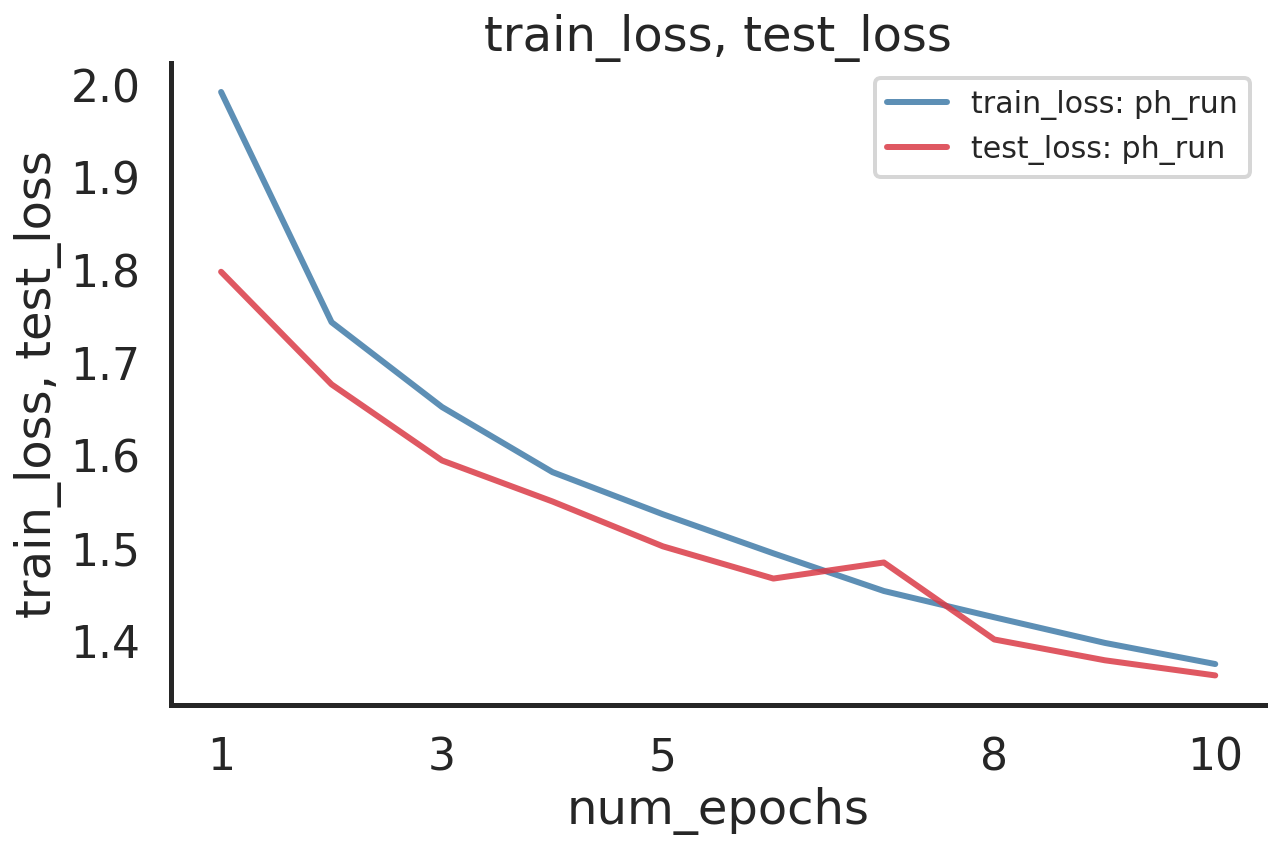

In [72]:
fig, ax = log.plot(['train_loss', 'test_loss'], 'num_epochs')

In [ ]:
weights = []
for i in range(train_params['num_model']):
  model = torch.load(f"test_all_stuff_{i}/models/final/final_seed_1234.pt")
  weight = []
  for layer in model:
    if "bias" not in layer:
      weight.extend(list(np.reshape(model[layer].cpu().detach().numpy(), -1)))
  weights.append(weight)
  cnt = 0
accum = 0.0
for i in range(train_params['num_model']):
  for j in range(train_params['num_model']):
    if j > i:
      accum += np.linalg.norm(np.array(weights[i]) - np.array(weights[j]))
      cnt += 1

print(f"L2 Norm: {accum / cnt}")


In [ ]:
from mle_logging import load_log
acc = []
for i in range(train_params['num_model']):
  val_acc = load_log(f"test_all_stuff_{i}/logs/log_seed_{experiment_seed}.hdf5").stats.test_accuracy
  acc.append(val_acc[-1])
print(f"STDDEV Accuracy : {np.std(acc)}")

In [ ]:
preds = []
def get_churn(arr1, arr2):
    assert arr1.shape == arr2.shape, 'Shape mismatch'
    return np.sum(arr1 == arr2) / arr1.size
for i in range(train_params['num_model']):
  temp = np.array(np.load(f"test_all_stuff_{i}/extra/predictions_epoch_{train_params['epochs']-1}.pkl", allow_pickle=True))
  preds.append(temp)


churn_tot = 0.0
cnt = 0
for i in range(train_params['num_model']):
  for j in range(train_params['num_model']):
    if j > i:
      cnt += 1
      churn_tot += get_churn(preds[i], preds[j])

print(f"Churn: {churn_tot / cnt}")